# Binary Classification on the MIT-BIH Arrhythmia Dataset

In [1]:
import h5py
from pathlib import Path
from copy import deepcopy

import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
print(f'torch version: {torch.__version__}')

torch version: 1.8.1+cu102


## Dataset

In [3]:
class BinaryECG(Dataset):
    """The class used by the client to load the dataset

    Args:
        Dataset ([type]): [description]
    """
    def __init__(self, train_path: Path, test_path: Path, train=True):
        if train:
            with h5py.File(train_path, 'r') as hdf:
                self.x = hdf['x_train'][:]
                self.y = hdf['y_train'][:]
                self.binary_y = deepcopy(self.y)  # for binary classification
                self.binary_y[self.binary_y > 0] = 1
        else:
            with h5py.File(test_path, 'r') as hdf:
                self.x = hdf['x_test'][:]
                self.y = hdf['y_test'][:]
                self.binary_y = deepcopy(self.y)
                self.binary_y[self.binary_y > 0] = 1
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.binary_y[idx])

In [4]:
batch_size = 4
train_dataset = BinaryECG(train=True, train_path="mitbih_train.hdf5", test_path="mitbih_test.hdf5")
test_dataset = BinaryECG(train=False, train_path="mitbih_train.hdf5", test_path="mitbih_test.hdf5")
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [34]:
print(train_dataset.x.shape)
print(train_dataset.y.shape)
print(test_dataset.x.shape)
print(test_dataset.y.shape)

(13245, 1, 128)
(13245,)
(13245, 1, 128)
(13245,)


(1, 128)


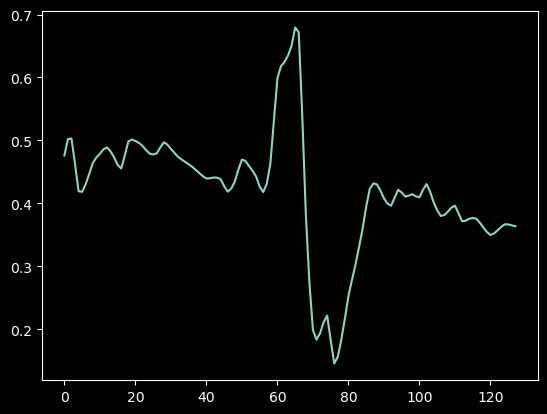

In [5]:
x0 = train_dataset.x[0]
print(x0.shape)
plt.plot(x0[0])

In [6]:
x0

array([[0.47613414, 0.5020567 , 0.50298215, 0.46231327, 0.41928844,
        0.41842108, 0.43061455, 0.44688531, 0.46408802, 0.47293354,
        0.47899632, 0.48582534, 0.48893095, 0.48258178, 0.47326914,
        0.46113493, 0.455493  , 0.47573456, 0.49812282, 0.50142268,
        0.49909754, 0.4960816 , 0.49134992, 0.4847633 , 0.47915717,
        0.47762139, 0.47941395, 0.48882176, 0.49701847, 0.49347912,
        0.48651553, 0.48023663, 0.47407637, 0.46977147, 0.46597436,
        0.46211728, 0.45808918, 0.45318487, 0.44824447, 0.44322334,
        0.43951277, 0.43997245, 0.4410783 , 0.44093789, 0.43854472,
        0.42746798, 0.41866831, 0.42362392, 0.43467756, 0.45355196,
        0.46949916, 0.46741965, 0.45934733, 0.45182872, 0.44276687,
        0.42654805, 0.41805189, 0.43117256, 0.46263137, 0.53157473,
        0.59875968, 0.61784347, 0.62479582, 0.63498664, 0.65088522,
        0.67939663, 0.6717122 , 0.53892088, 0.38295176, 0.27504905,
        0.19901058, 0.18376322, 0.19361621, 0.21

In [69]:
print(f"{train_dataset.binary_y = }")
print(f"{train_dataset.y = }")

unique, train_counts = np.unique(train_dataset.binary_y, return_counts=True)
print(f"there are {train_counts[0]} normal beats and {train_counts[1]} abnormal beats in the train dataset")
unique, test_counts = np.unique(test_dataset.binary_y, return_counts=True)
print(f"there are {test_counts[0]} normal beats and {test_counts[1]} abnormal beats in the train dataset")

train_dataset.binary_y = array([1, 1, 1, ..., 1, 1, 0])
train_dataset.y = array([2, 4, 2, ..., 1, 4, 0])
there are 3000 normal beats and 10245 abnormal beats in the train dataset
there are 3000 normal beats and 10245 abnormal beats in the train dataset


## Model

A simple linear regression model

In [9]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        y_pred = self.linear(x)
        y_pred = self.sigmoid(y_pred)
        return y_pred

## Training

In [74]:
epoch = 100
lr = 0.001

In [13]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'device: {torch.cuda.get_device_name(0)}')

def train():
    lr_model = LinearModel(128, 1)
    lr_model.to(device)

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(lr_model.parameters(), lr=lr)

    train_losses = []
    accuracies = []

    for e in range(epoch):
        print(f"--------- epoch: {e+1} ---------")
        train_loss = 0.0
        corrects = 0
        total_examples = 0
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()  # zero the gradients
            # prepare data
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            # the forward pass
            y_pred = lr_model(x)
            y_pred = y_pred.reshape(y.shape)
            # the backward pass
            loss = criterion(y_pred, y)  # calculate the loss
            loss.backward()  # get the gradients
            optimizer.step()  # update the params based on the gradients
            # collect training results
            train_loss += loss.item()
            corrects += torch.sum((y_pred.round() == y))
            total_examples += len(y)
            # print(f"{y = }, {y_pred.round() = }")
            # print(f"corrects = {corrects.item()}")

        print(f"corrects / total_examples = {corrects.item()} / {total_examples}")
        train_losses.append(train_loss / len(train_loader))
        accuracies.append(corrects / total_examples)
        print(f"loss = {train_losses[-1]:.4f}")
        print(f"accuracy = {accuracies[-1]:.2f}")
        # print(total_examples)
        

train()